<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-14 11:43:49--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-07-14 11:43:50 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

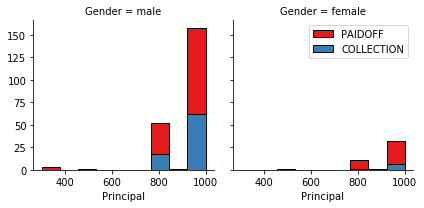

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

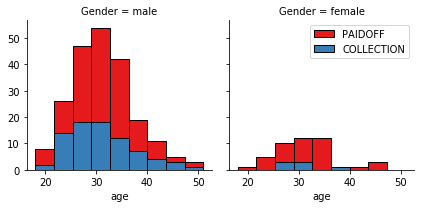

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

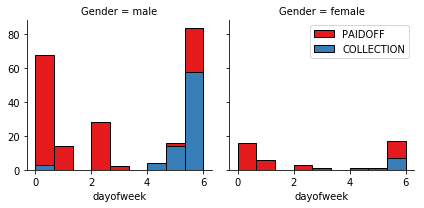

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## Step 1
Fist the necessary import statements are needed to convert the data into train/test data. 80% is used for training and 20% is used for testing. The result of this code are four datasets:
- X_train = a dataset containing of 80% of the data with the features 
- y_train = a dataset containing of 80% of the data with the class labels
- X_test = a dataset containing of 20% of the data with the features 
- y_test = a dataset containing of 20% of the data with the class labels 

In [19]:
# Import statements
from sklearn.model_selection import train_test_split #train/test
from sklearn.neighbors import KNeighborsClassifier #Algorithm
from sklearn import metrics #Metrics

# Splitting the data into train/test data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4) # 0.2=20% test data
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


## Step 2
Step 2 is creating a loop for the different K's we want to test the classifier. Here we are going to test K ranging from 1 to 25. The result is a numpy array with the accuray for the different K's. So the first result corresponds to k=1. This also explains the (Ks-1), because Python starts the index at 0.

In [20]:
# Set the number of K we want to try
Ks = 25
mean_acc = np.zeros((Ks-1)) # -1 because of the 0 index of Python
std_acc = np.zeros((Ks-1)) # -1 because of the 0 index of Python

# Loop over the different K's ranging from 1 to the set K
for n in range(1, Ks):
    
    # Each time Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train) #Train
    yhat=neigh.predict(X_test) #Predict
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # -1 because of the 0 index of Python
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       , 0.68571429,
       0.71428571, 0.68571429, 0.7       , 0.7       ])

## Step 3
In the next step we can plot the numpy array we created in step 2. Check the comments to see what exactly is happening.

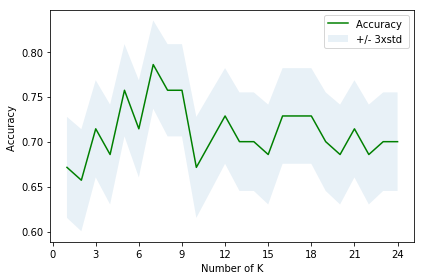

In [21]:
fig, ax = plt.subplots()

# Be sure to only pick integer tick locations (non-integer makes no sense for K).
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot the data
ax.plot(range(1,Ks),mean_acc,'g')

# Just for appearance's sake
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of K')
fig.tight_layout()

plt.show()

## Step 4
In this final step of the KNN algorimth we print the highest value of the numpy array (<code>mean_acc.max()</code>, with the corresponding index number <code>mean_acc.argmax()+1)</code>). Finnaly we can create an confusion matrix with k=7. Unfortunately, plot_confusion_matrix is only available from sklearn 0.22 and onwards (it is also not possible to upgrade the current version as this is an online environment). You can check out the Python code below to see how this works in the newer version of Scikit-learn.

In [22]:
#from sklearn.metrics import plot_confusion_matrix
#
#neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
#plot_confusion_matrix(neigh, X_test, y_test,
#                                cmap='Blues',
#                                 normalize=None)

print( "The best accuracy was with {0:.2f} with k={1}".format(mean_acc.max(), mean_acc.argmax()+1) )

The best accuracy was with 0.79 with k=7


# Decision Tree

## Step 1
Just like the KNN algorithm we have to split the data into test and into train data.

In [23]:
from sklearn.tree import DecisionTreeClassifier
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=4)

## Step 2
In this step we will fit the Classifier onto the training set data. We used depth 4 (randomly chosen) en print out the accuracy.

In [24]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_trainset,y_trainset)
predTree = loanTree.predict(X_testset)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6142857142857143


## Step 3
We achieved an accuracy of 61% with a tree depth of 4. But at what depth do we achieve the highest accuracy? In the this step we apply the same technique we used to determine the best K (KNN classifier).

In [25]:
# Set the number of Depths we want to try
Depth = 15
mean_acc_tree = np.zeros((Depth-1))
std_acc_tree = np.zeros((Depth-1))

# Loop over the different Depth's ranging from 1 to the set Depth
for n in range(1, Depth):
    
    # Each time Train Model and Predict
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    loanTree.fit(X_trainset,y_trainset)
    yhat = loanTree.predict(X_testset)
    mean_acc_tree[n-1] = metrics.accuracy_score(y_testset, yhat)

    
    std_acc_tree[n-1]=np.std(yhat==y_testset)/np.sqrt(yhat.shape[0])

mean_acc_tree

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286, 0.65714286, 0.7       ,
       0.7       , 0.7       , 0.71428571, 0.71428571])

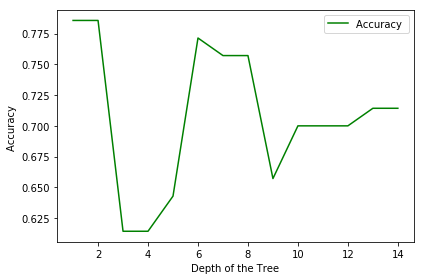

In [26]:
fig, ax = plt.subplots()

# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot the data
ax.plot(range(1, Depth), mean_acc_tree,'g')

# Just for appearance's sake
#plt.fill_between(range(1, Depth), mean_acc_tree - 1 * std_acc_tree,mean_acc_tree + 1 * std_acc_tree, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth of the Tree')
fig.tight_layout()

plt.show()

In [28]:
print( "The best accuracy was with {0:.2f} with depth={1}".format(mean_acc_tree.max(), mean_acc_tree.argmax()+1) )

The best accuracy was with 0.79 with depth=1


## Step 4
Apparently with a depth of 1 the tree performs best. Finnaly, we can also print the tree, because it is highly interpretable we can see what is happening. We see that both leaves end in "PAIDOFF". Because a large portion of the data is labeled "PAIDOFF" all the leaves end there. To prevent underfitting of the tree we will use depth=6, as we can see from the graph this gives also a pretty high accuracy score.

[Text(1453.125, 2123.4375, 'weekend <= -0.188\nentropy = 0.823\nsamples = 276\nvalue = [71, 205]\nclass = PAIDOFF'),
 Text(726.5625, 707.8125, 'entropy = 0.126\nsamples = 116\nvalue = [2, 114]\nclass = PAIDOFF'),
 Text(2179.6875, 707.8125, 'entropy = 0.986\nsamples = 160\nvalue = [69, 91]\nclass = PAIDOFF')]

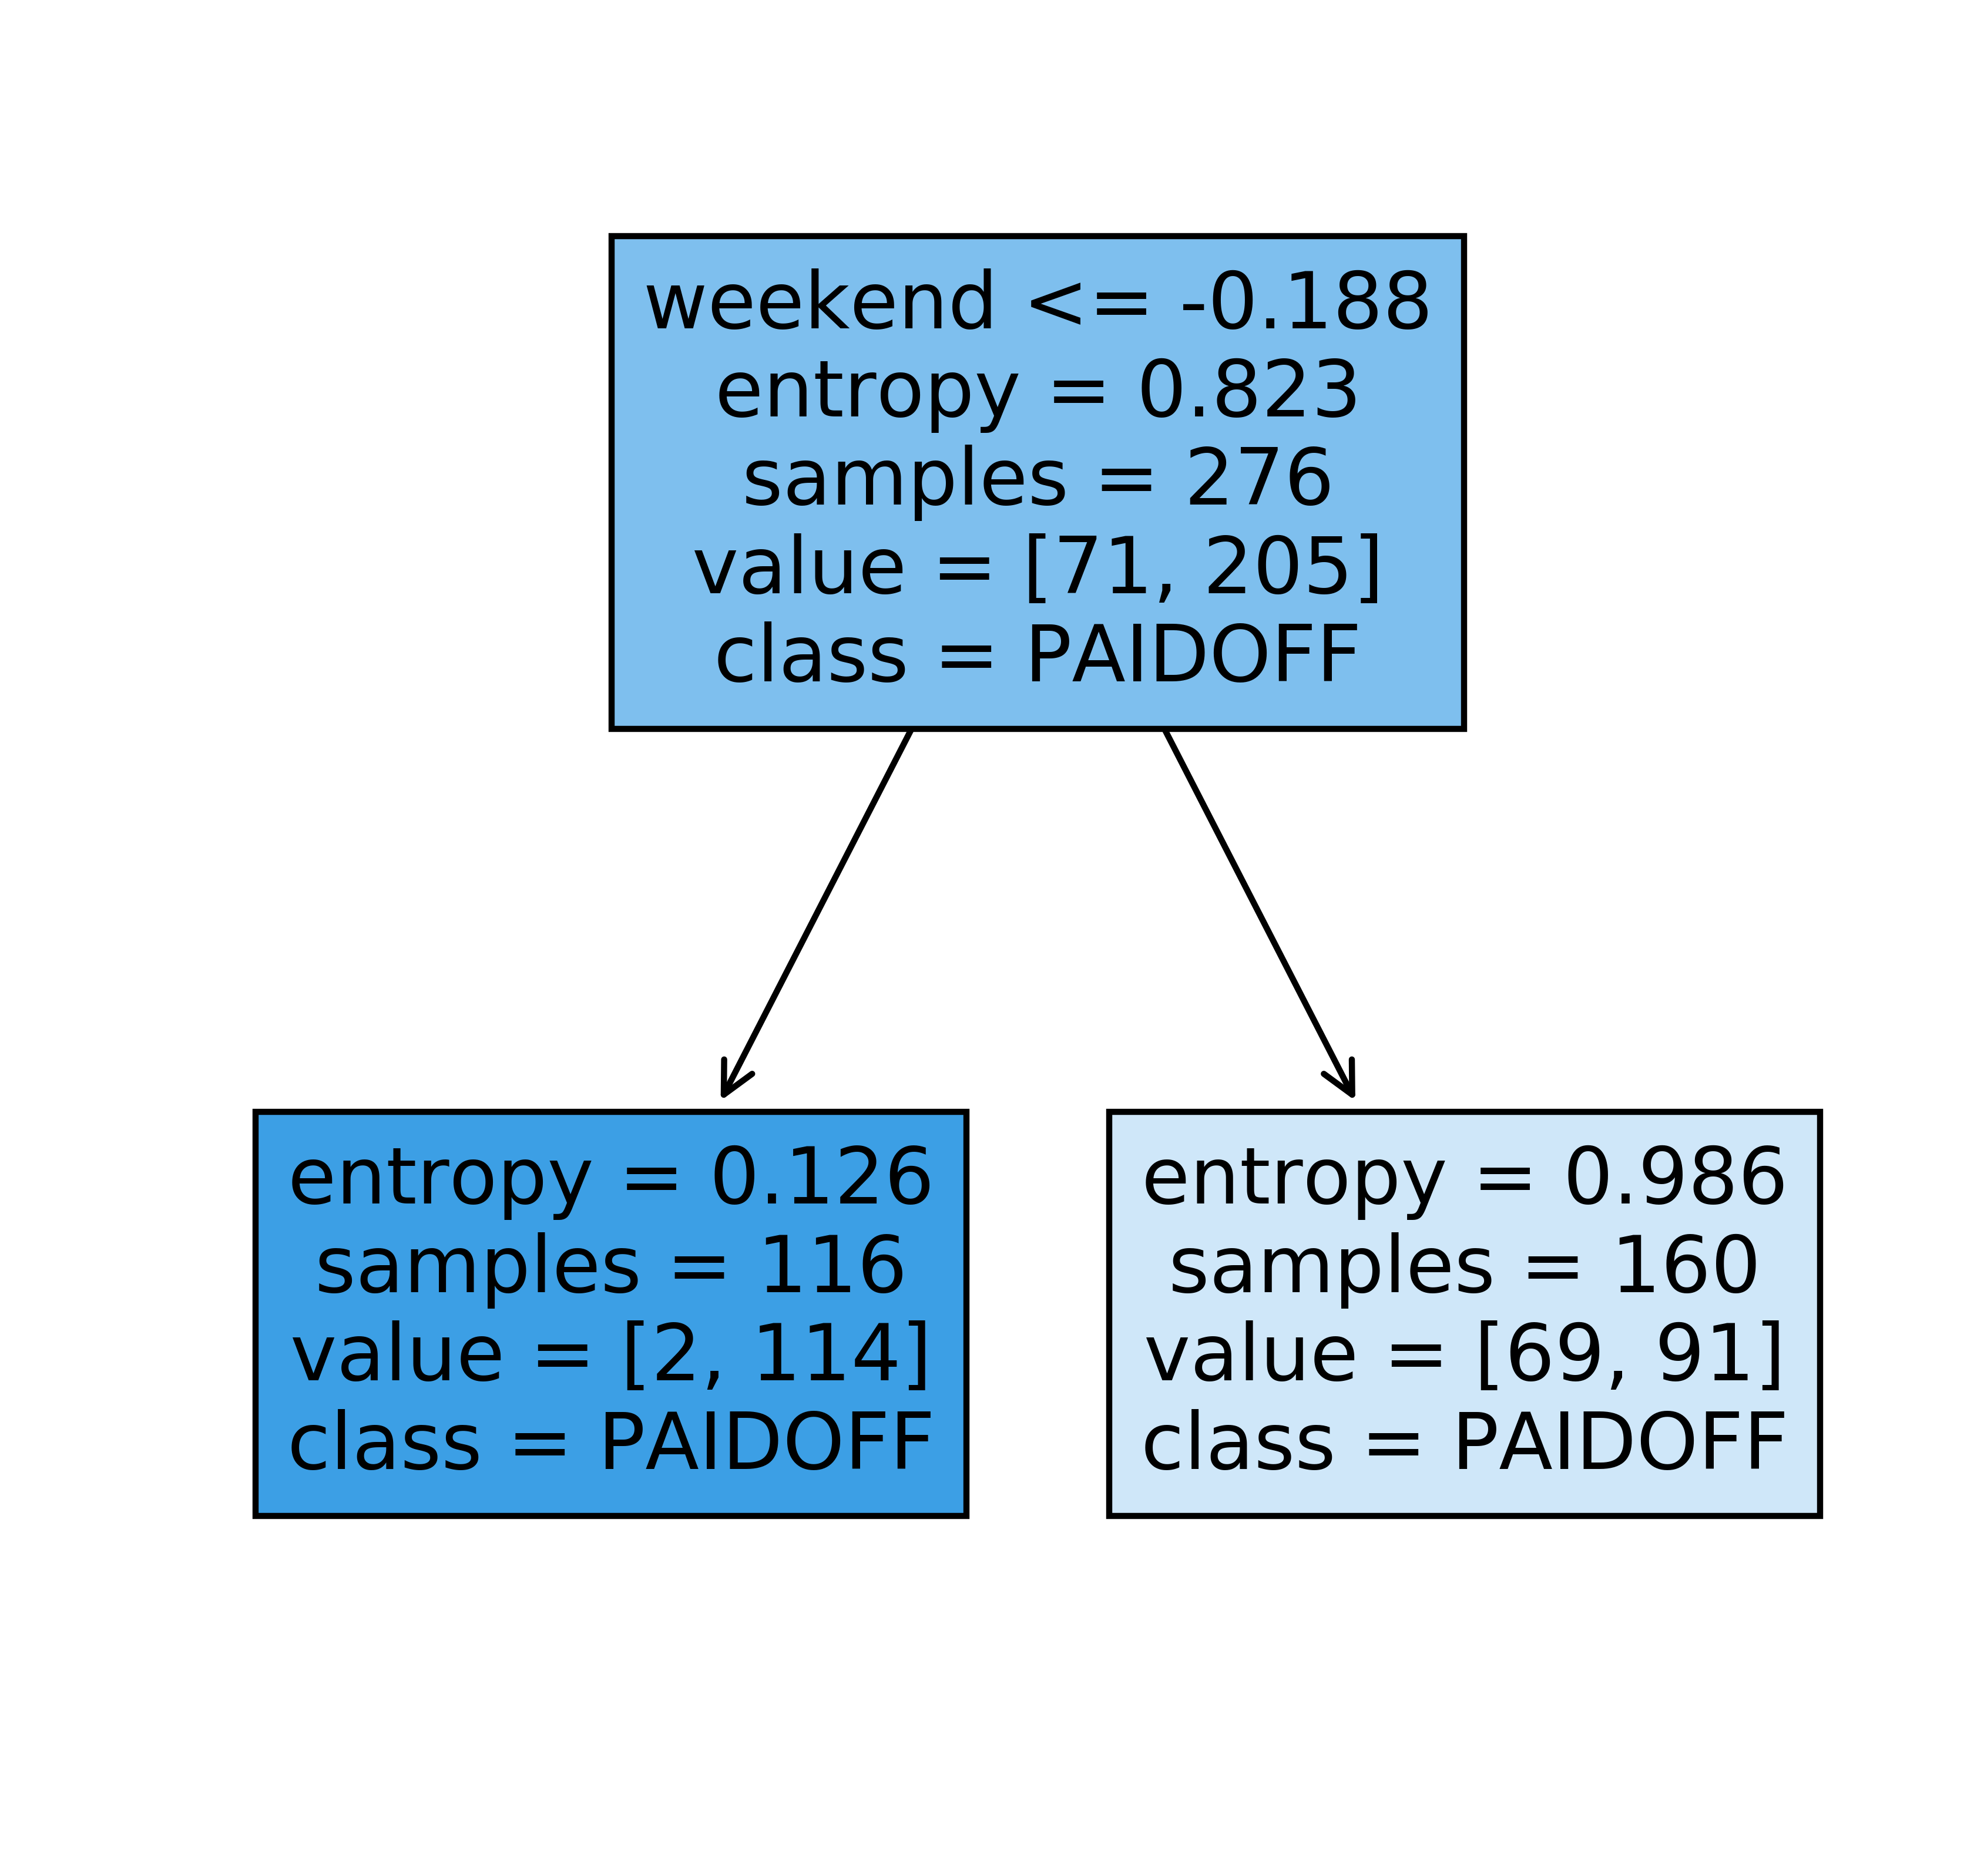

In [29]:
from sklearn import tree

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 1)
loanTree = loanTree.fit(X_trainset, y_trainset)
predTree = loanTree.predict(X_testset)

fn = list(Feature)
cn = ['COLLECTION', 'PAIDOFF']

fig, axes = plt.subplots(figsize = (5, 5), dpi=750)

tree.plot_tree(loanTree,
               feature_names = fn, 
               class_names = cn,
               filled = True)

# fig.savefig('test.png')

# Support Vector Machine

## Step 1
We import the Support Vector Machine and we this time just use the train/test data created with the Decision Tree classifier. Next we set the variable clf to contain the SVM and we update it to the train data. We use the standard kernel (Radial Basis Function).

In [30]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf = clf.fit(X_train, y_train) 

## Step 2
We can use the trained classifier (clf) to predict variables of the X_test data set and compare them with the y_test dataset.

In [31]:
yhat = clf.predict(X_test)
print(yhat [0:10])
print(y_test[0:10])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Step 3
Finally, we can create an confusion matrix to check the results. It looks like there are a lot of false/negatives (11 out of 15) compared to the total number of true positives. We will compute the statistics in the final chapter of this notebook. (See the comment about the version of scikit-learn. Fortunately we have some other metrics as the f1 score to compare Algorithms.

In [32]:
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(clf, X_test, y_test,
#                                 cmap='Blues',
#                                 normalize=None)

In [33]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.7275882012724117

# Logistic Regression

## Step 1
First, we import the Logistic Regression Algorithm. Next we use the previously created train and test set data to train the algorithm.

In [34]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1, solver='liblinear').fit(X_train, y_train)

## Step 2
Next, we can try to predict the classes for the x_test dataset. From the printout we can see that the first columns corresponds to the 'COLLECTION' label (first column has to be greater then 0.5) and the second column to 'PAIDOFF' (second column greater then 0.5).

In [35]:
yhat_LR = LR.predict(X_test)
yhat_prob_LR = LR.predict_proba(X_test)


for i, j in zip(yhat_prob_LR[0:5], yhat_LR[0:5]):
    print(i, '=', j)

[0.52329119 0.47670881] = COLLECTION
[0.39312075 0.60687925] = PAIDOFF
[0.02860977 0.97139023] = PAIDOFF
[0.04250212 0.95749788] = PAIDOFF
[0.02877408 0.97122592] = PAIDOFF


## Step 3
Finnaly we can print the confusion matrix for the Logistic Regression Algorithm.

In [36]:
#plot_confusion_matrix(LR, X_test, y_test,
#                                 cmap='Blues',
#                                 normalize=None)

# Model Evaluation using Test set

In [38]:
from sklearn.metrics import jaccard_score # Use Jaccard score instead of Jaccard Similarity Score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [39]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-14 11:52:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-14 11:52:15 (225 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [40]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## Step 1
We first alter the data so we have the same dataframe as the training data and also have scaled data

In [41]:
test_df['due_date'] = pd.to_datetime(df['due_date']) # To DateTime
test_df['effective_date'] = pd.to_datetime(df['effective_date']) # To DateTime
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek # Creates week date
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) # Create Weekend yes/no
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True) # Convert Gender to an int
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
X_test = Feature_test
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_test = test_df['loan_status'].values

# Step 2
Now we can train the classifiers again with the optimal variables (e.g. K=7). We train (fit) the data on the training set and we predict the data on X_test (loan_test.csv). Next we can use y and yhat to calculate the accuracy scores.

In [42]:
#Train Model and Predict KNN  
KNN = KNeighborsClassifier(n_neighbors = 7).fit(X_trainset, y_trainset) # Use K = 7, this was the optimum K
yhatKNN = KNN.predict(X_test) 
KNN_JS = jaccard_score(y_test, yhatKNN, pos_label='PAIDOFF') # Use Jaccard Score, Similarity index is removed in newer Sklearn.
KNN_F1 = f1_score(y_test, yhatKNN, pos_label='PAIDOFF')

# Train Model and Predict Decision Tree
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6).fit(X_trainset, y_trainset)
yhatDT = loanTree.predict(X_test)
DT_JS = jaccard_score(y_test, yhatDT, pos_label='PAIDOFF')
DT_F1 = f1_score(y_test, yhatDT, pos_label='PAIDOFF')

# Train Model and Predict SVM
SVM = svm.SVC(kernel='rbf').fit(X_trainset, y_trainset)
yhatSVM = SVM.predict(X_test)
SVM_JS = jaccard_score(y_test, yhatSVM, pos_label='PAIDOFF')
SVM_F1 = f1_score(y_test, yhatSVM, pos_label='PAIDOFF')

# Train Model and Predict Logistic Regression
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_trainset, y_trainset)
yhatLR = LR.predict(X_test)
yhat_prob_LR = LR.predict_proba(X_test)
LR_JS = jaccard_score(y_test, yhatLR, pos_label='PAIDOFF')
LR_F1 = f1_score(y_test, yhatLR, pos_label='PAIDOFF')
LR_LL = log_loss(y_test, yhat_prob_LR)

data = [['KNN', KNN_JS, KNN_F1, 'NA'],
       ['Decision Tree', DT_JS, DT_F1, 'NA'],
       ['SVM', SVM_JS, SVM_F1, 'NA'],
       ['Logistic Regression', LR_JS, LR_F1, LR_LL]]

Accuracy_DF = pd.DataFrame(data, columns = ['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']) 

## Step 3
The final step is to create a pandas dataframe for easy interpretability. Apparently the the SVM classifier did the best job. The KNN and the Decision Tree predicted the same amount of cases right and wrong, this explains their similar scores. The Logistic Regression predicted all the cases as "PAIDOFF". The Logloss is also pretty high, the algorith has a lot of trouble to predict points with a high certainty or in this case predicts the points as "PAIDOFF" and get penalized for predicting "COLLECTION" as "PAIDOFF".

In [43]:
Accuracy_DF

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.673077,0.804598,NA
1,Decision Tree,0.673077,0.804598,NA
2,SVM,0.795918,0.886364,NA
3,Logistic Regression,0.740741,0.851064,0.547395


## END

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>